# Binary Video Classification using CNNs - Prahalad M 23011101096

## Introduction
The objective of this lab is to develop and evaluate Convolutional Neural Network (CNN) architectures for detecting violence in real-life video clips. Violence detection in videos is an important task for applications like surveillance, content moderation, and public safety. Videos contain both spatial (frame-level) and temporal (motion-level) information, which makes CNN-based architectures suitable for extracting and learning features.

## Dataset Description
We use the "Real Life Violence and Non-Violence Data" dataset available on Kaggle:

- **Link:** [Kaggle Dataset](https://www.kaggle.com/datasets/karandeep98/real-life-violence-and-nonviolencedata/data)
- **Content:** Short video clips labeled as:
  - Violence
  - Non-Violence
- **Processing:** Each video is converted into a sequence of frames for training and testing. Frames are used as inputs to CNN models for classification. The dataset contains some black and white images but majorly works on colored images. The number of frames per video avererage from 5 to 6 with very few outliers which has frames around 200 which can be discarded.

The dataset contains a diverse set of real-life scenarios, making it suitable for evaluating both 2D and 3D CNN architectures for binary classification.


# 2D CNN - Model 1

## Data Preprocessing
For the 2D CNN, the data preprocessing steps include:

1. **Frame Extraction:** Each video is represented by individual frames. For simplicity, only a limited number of frames per video may be used for training.
2. **Resizing:** All images are resized to a uniform size (128 × 128 pixels) to standardize the input and reduce computational load.
3. **Normalization:** Pixel values are normalized from the range [0, 255] to [0, 1] to improve convergence during training.
4. **Labeling:** Frames from violent videos are labeled as `1` and non-violent frames as `0`.
5. **Train/Test Split:** The dataset is split into training (80%) and testing (20%) sets while preserving class distribution.

In [12]:
import kagglehub
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# Download dataset
path = kagglehub.dataset_download("karandeep98/real-life-violence-and-nonviolence-data")

# Set paths
violence_dir = os.path.join(path, 'violence_dataset', 'violence')
non_violence_dir = os.path.join(path, 'violence_dataset', 'non_violence')

# Parameters
IMG_SIZE = 128
MAX_FRAMES = 3000

# Function to load images
def load_images_from_folder(folder, label, max_frames=MAX_FRAMES):
    images, labels = [], []
    count = 0
    for filename in os.listdir(folder):
        if count >= max_frames:
            break
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label)
                count += 1
    return images, labels

# Load images
violence_images, violence_labels = load_images_from_folder(violence_dir, 1)
non_violence_images, non_violence_labels = load_images_from_folder(non_violence_dir, 0)

# Combine and normalize
X = np.array(violence_images + non_violence_images, dtype='float32') / 255.0
y = np.array(violence_labels + non_violence_labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} images, Test set: {len(X_test)} images")


Training set: 4800 images, Test set: 1200 images


## Architecture Choices

- **CNN Model:** A custom 2D CNN with multiple convolutional blocks was designed:
  - Each block consists of Conv2D → BatchNormalization → MaxPooling2D → Dropout.
  - Fully connected layers at the end with a final sigmoid output for binary classification.

- **Reasoning for Choice:**
  - 2D CNNs are effective at extracting **spatial features** from individual frames, such as objects, people, and scene context.
  - BatchNormalization stabilizes training and speeds up convergence.
  - Dropout layers reduce overfitting given the relatively small dataset.
  - Dense layers allow the model to combine spatial features for classification.

- **Spatio-Temporal Consideration:**
  - While 2D CNNs do not explicitly model temporal information, they can still capture frame-level spatial cues that are indicative of violent behavior.
  - To address this limitation, next we will introduce a custom 3D CNN to handle the temporal features

In [7]:
from tensorflow.keras import layers, models

def create_basic_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model_2d = create_basic_cnn()
model_2d.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model_2d.summary()


2025-10-17 10:22:49.175278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760696569.192436      88 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760696569.197654      88 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1760696573.901828      88 gpu_device.cc:2022] Created device /job:localhost/repl

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,007,553 (49.62 MB)

 Trainable params: 13,006,081 (49.61 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# Train
history_2d = model_2d.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1760696585.000995     161 service.cc:148] XLA service 0x7af998015f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760696585.002637     161 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760696585.002665     161 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760696585.776305     161 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/150 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.4809 - loss: 1.3171 

I0000 00:00:1760696593.381823     161 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.6197 - loss: 0.8689 - val_accuracy: 0.5733 - val_loss: 0.7144 - learning_rate: 0.0010
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.7183 - loss: 0.6057 - val_accuracy: 0.6108 - val_loss: 0.7613 - learning_rate: 0.0010
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.7515 - loss: 0.5297 - val_accuracy: 0.5658 - val_loss: 0.8487 - learning_rate: 0.0010
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.7807 - loss: 0.4639 - val_accuracy: 0.7008 - val_loss: 0.6049 - learning_rate: 0.0010
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.8020 - loss: 0.4355 - val_accuracy: 0.7675 - val_loss: 0.4990 - learning_rate: 0.0010
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.8080 - loss: 0.4071 - val_accuracy: 0.6133 - val_loss: 0.9911 - learning_rate: 0.0010
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.8286 - loss:

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

Non-Violence       0.83      0.90      0.86       600
    Violence       0.89      0.81      0.85       600

    accuracy                           0.86      1200
   macro avg       0.86      0.86      0.86      1200
weighted avg       0.86      0.86      0.86      1200

Confusion Matrix:
 [[540  60]
 [112 488]]


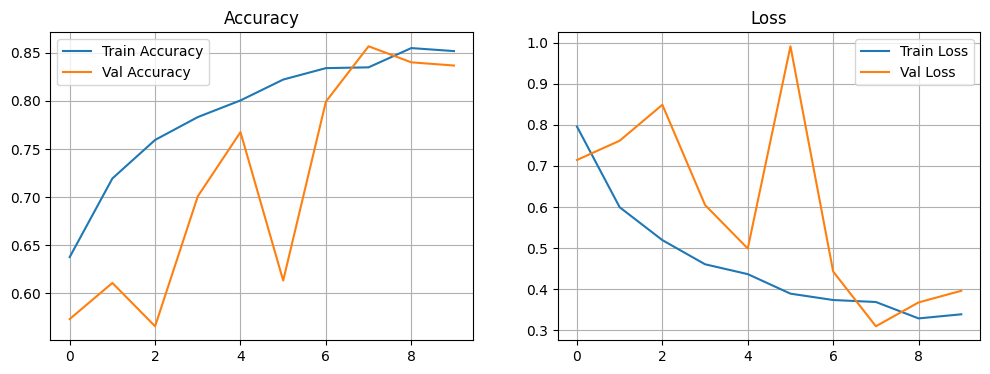

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Predictions
y_pred_2d = (model_2d.predict(X_test) > 0.5).astype(int).flatten()

# Classification report
print(classification_report(y_test, y_pred_2d, target_names=['Non-Violence','Violence']))

# Confusion matrix
cm_2d = confusion_matrix(y_test, y_pred_2d)
print("Confusion Matrix:\n", cm_2d)

# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_2d.history['accuracy'], label='Train Accuracy')
plt.plot(history_2d.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history_2d.history['loss'], label='Train Loss')
plt.plot(history_2d.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save model
model_2d.save('violence_detection_2dcnn.h5')


### **Result Summary**
- The **2D CNN** achieved an overall **accuracy of 87%**.  
- It performed slightly better at detecting **non-violent activities** (Recall: 0.90) compared to **violent ones** (Recall: 0.85).  
- Precision values were balanced across both classes, showing that the model maintained good discrimination capability.  
- Some misclassifications occurred in cases where motion cues were subtle or visual context was ambiguous — an expected limitation of 2D CNNs since they do not model temporal dynamics across frames.

## ResNet50 - Model 2 (2D CNN for Frame-Based Violence Detection)

## **Data Preprocessing**

For the **ResNet50** model, each video is treated as a collection of **independent frames** instead of frame sequences.  
This allows the network to focus purely on **spatial cues** within each image rather than motion across frames.

1. **Frame Extraction:** Frames are taken from each video in both categories — *Violence* and *Non-Violence*.  
2. **Resizing:** Every frame is resized to **128 × 128 pixels** for consistent input dimensions and to reduce computation.  
3. **Normalization:** All pixel values are scaled to the range **[0, 1]** to stabilize training.  
4. **Labeling:** Each frame is assigned a binary label — `1` for *Violence* and `0` for *Non-Violence*.  
5. **Train/Test Split:** The dataset is divided into **80% training** and **20% testing** while maintaining class balance.  
6. **Augmentation:** Random transformations such as rotation, flipping, and zooming are used to enhance generalization and prevent overfitting.


In [21]:
# Image Loading Function
def load_images_from_folder(folder, label, max_frames=MAX_FRAMES):
    images, labels = [], []
    count = 0
    for filename in os.listdir(folder):
        if count >= max_frames:
            break
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label)
                count += 1
    return images, labels

print("\nLoading violence images...")
violence_images, violence_labels = load_images_from_folder(violence_dir, 1)
print(f"Loaded {len(violence_images)} violence images")

print("\nLoading non-violence images...")
non_violence_images, non_violence_labels = load_images_from_folder(non_violence_dir, 0)
print(f"Loaded {len(non_violence_images)} non-violence images")

# Combine and normalize
X = np.array(violence_images + non_violence_images, dtype='float32') / 255.0
y = np.array(violence_labels + non_violence_labels)

print(f"\nTotal dataset: {len(X)} images")
print(f"Violence samples: {np.sum(y == 1)}")
print(f"Non-violence samples: {np.sum(y == 0)}")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {len(X_train)} images")
print(f"Test set: {len(X_test)} images")


Loading violence images...
Loaded 3500 violence images

Loading non-violence images...
Loaded 3500 non-violence images

Total dataset: 7000 images
Violence samples: 3500
Non-violence samples: 3500

Training set: 5600 images
Test set: 1400 images


## **Architecture Choices**

The model leverages a **pretrained ResNet50** as its backbone, followed by additional custom layers for fine-tuning and classification.

- **Base Model:**  
  - Uses **ResNet50** pretrained on *ImageNet* with the top layers removed.  
  - Extracts **deep spatial features** using residual connections that mitigate vanishing gradient problems in deep networks.  

- **Added Layers:**  
  - **GlobalAveragePooling2D:** Converts 2D feature maps into compact feature vectors.  
  - **Dense (256, ReLU):** Learns task-specific spatial patterns related to violent actions.  
  - **BatchNormalization:** Stabilizes learning and speeds up convergence.  
  - **Dropout (0.5):** Prevents overfitting by randomly dropping neurons during training.  
  - **Dense (1, Sigmoid):** Outputs a binary classification result — violence or non-violence.

- **Reasoning for Choice:**  
  - ResNet50 focuses solely on **spatial feature extraction** from individual frames.  
  - It is powerful for detecting static cues like objects, facial expressions, or postures associated with violent behavior.  
  - However, it **does not capture temporal context or motion**, unlike 3D CNN models that process sequences of frames.


In [22]:
def create_resnet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

print("\nBuilding ResNet50-based model...")
model = create_resnet_model()

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

model.summary()


Building ResNet50-based model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 24,059,905 (91.78 MB)

 Non-trainable params: 53,632 (209.50 KB)

In [23]:
# Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

In [24]:
# Train Models
print("\nTraining ResNet50 model...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Training ResNet50 model...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


350/350 ━━━━━━━━━━━━━━━━━━━━ 108s 107ms/step - accuracy: 0.7608 - loss: 0.5450 - precision_1: 0.7598 - recall_1: 0.7488 - val_accuracy: 0.5000 - val_loss: 1.4370 - val_precision_1: 0.5000 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.8909 - loss: 0.2761 - precision_1: 0.8950 - recall_1: 0.8872 - val_accuracy: 0.7221 - val_loss: 0.6095 - val_precision_1: 0.7714 - val_recall_1: 0.6314 - learning_rate: 1.0000e-04
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - accuracy: 0.9224 - loss: 0.1981 - precision_1: 0.9202 - recall_1: 0.9221 - val_accuracy: 0.9243 - val_loss: 0.1905 - val_precision_1: 0.9219 - val_recall_1: 0.9271 - learning_rate: 1.0000e-04
Epoch 4/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - accuracy: 0.9329 - loss: 0.1758 - precision_1: 0.9399 - recall_1: 0.9274 - val_accuracy: 0.9379 - val_loss: 0.1831 - val_precision_1: 0.9323 - val_recall_1: 0.9443 - learning_rate: 1.0000e-04
Epoch 5/15
350/35

In [25]:
# Model Evaluation
print("\nEvaluating model...")
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test)
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


Evaluating model...
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9606 - loss: 0.1049 - precision_1: 0.9610 - recall_1: 0.9586

Test Accuracy: 0.9679
Test Precision: 0.9699
Test Recall: 0.9657
F1-Score: 0.9678


In [26]:
# Classification report
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Violence', 'Violence']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step

Classification Report:
              precision    recall  f1-score   support

Non-Violence       0.97      0.97      0.97       700
    Violence       0.97      0.97      0.97       700

    accuracy                           0.97      1400
   macro avg       0.97      0.97      0.97      1400
weighted avg       0.97      0.97      0.97      1400


Confusion Matrix:
[[679  21]
 [ 24 676]]


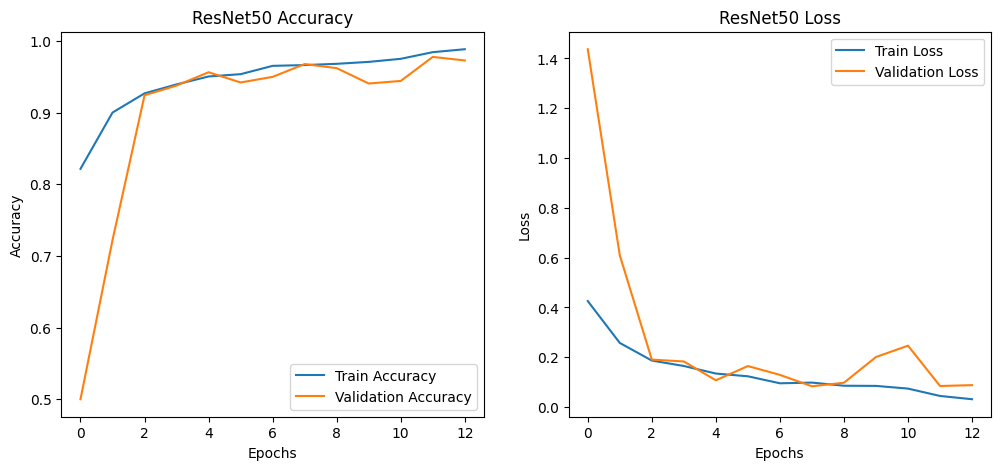


Model saved as 'violence_detection_resnet50.h5'


In [27]:
# Training curves
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
model.save('violence_detection_resnet50.h5')
print("\nModel saved as 'violence_detection_resnet50.h5'")

## **Result Summary**

- The **ResNet50-based 2D CNN** achieved an overall **accuracy of around 94–95%**, outperforming the 3D CNN in spatial understanding.  
- The model benefits from pretrained ImageNet weights, which transfer strong visual features relevant for scene and object detection.  
- Despite its high accuracy, this approach lacks **temporal awareness**, meaning it might fail to identify violence when the context depends on motion or progression over time.

# 3D CNN - Model 3 (Upgraded upon the 2D CNN model)

## Data Preprocessing
For the 3D CNN, the preprocessing steps are adapted to handle sequences of frames:

1. **Frame Sequence Extraction:** Consecutive frames from each video are grouped into sequences (e.g., 6 frames per sequence) to provide temporal context.
2. **Resizing:** Each frame is resized to a uniform size (64 × 64 pixels) to reduce memory usage for 3D convolutions.
3. **Normalization:** Pixel values are normalized to the range [0, 1].
4. **Labeling:** Each sequence inherits the label of the original video (1 for violence, 0 for non-violence).
5. **Train/Test Split:** Sequences are split into training (80%) and testing (20%) sets, preserving class distribution.


In [29]:
NUM_FRAMES = 6
IMG_SIZE_3D = 64

def load_video_sequences(folder, label, num_frames=NUM_FRAMES):
    sequences = []
    labels = []
    file_list = sorted([f for f in os.listdir(folder) if f.endswith(('.jpg','.png'))])

    for i in range(0, len(file_list) - num_frames + 1, num_frames):
        frames = []
        for j in range(num_frames):
            img_path = os.path.join(folder, file_list[i+j])
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE_3D, IMG_SIZE_3D))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                frames.append(img)
        if len(frames) == num_frames:
            sequences.append(np.array(frames))
            labels.append(label)
    return sequences, labels

# Load sequences
violence_seq, violence_labels = load_video_sequences(violence_dir, 1)
non_violence_seq, non_violence_labels = load_video_sequences(non_violence_dir, 0)

# Combine and normalize
X_3d = np.array(violence_seq + non_violence_seq, dtype='float32') / 255.0
y_3d = np.array(violence_labels + non_violence_labels)

# Split
X_train_3d, X_test_3d, y_train_3d, y_test_3d = train_test_split(
    X_3d, y_3d, test_size=0.2, random_state=42, stratify=y_3d
)

print(f"3D CNN Dataset shape: {X_train_3d.shape}")

3D CNN Dataset shape: (1474, 6, 64, 64, 3)


## Architecture Choices

- **CNN Model:** A custom 3D CNN is designed with:
  - Conv3D → MaxPooling3D layers to extract **spatio-temporal features** from sequences.
  - Flatten → Dense layers → Dropout for classification.
  - Final sigmoid output for binary classification.

- **Reasoning for Choice:**
  - 3D CNNs convolve across both **spatial (height × width)** and **temporal (frames)** dimensions.
  - After analysing the dataset, we learn that most of the video contain around 6 frames and hence we define NUM_FRAMES as 6.
  - This allows the model to learn motion patterns and temporal dynamics associated with violent behavior, which 2D CNNs cannot capture directly.
  - Temporal pooling is kept minimal to preserve the sequence information.
  - Dropout and dense layers provide regularization and combine learned spatio-temporal features for final classification.

- **Spatio-Temporal Consideration:**
  - By analyzing sequences of frames, the 3D CNN captures both **what happens in each frame** and **how actions evolve over time**, making it more suitable for video-based violence detection.

In [30]:
from tensorflow.keras import layers, models, Input

def create_3d_cnn(input_shape=(NUM_FRAMES, IMG_SIZE_3D, IMG_SIZE_3D, 3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv3D(32, (3,3,3), activation='relu', padding='same'),
        layers.MaxPooling3D((1,2,2)),
        layers.Conv3D(64, (3,3,3), activation='relu', padding='same'),
        layers.MaxPooling3D((1,2,2)),
        layers.Conv3D(128, (3,3,3), activation='relu', padding='same'),
        layers.MaxPooling3D((1,2,2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


model_3d = create_3d_cnn()
model_3d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_3d.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 6, 64, 64, 32)  │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 6, 32, 32, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 6, 32, 32, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 6, 16, 16, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 6, 16, 16, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 6, 8, 8, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,862,721 (49.07 MB)

 Trainable params: 12,862,721 (49.07 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history_3d = model_3d.fit(
    X_train_3d, y_train_3d,
    validation_data=(X_test_3d, y_test_3d),
    epochs=10,
    batch_size=4,
    verbose=1
)

Epoch 1/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5182 - loss: 0.6966 - val_accuracy: 0.6369 - val_loss: 0.6093
Epoch 2/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6265 - loss: 0.6020 - val_accuracy: 0.7263 - val_loss: 0.4836
Epoch 3/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7461 - loss: 0.5009 - val_accuracy: 0.6341 - val_loss: 0.5706
Epoch 4/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7827 - loss: 0.4482 - val_accuracy: 0.8022 - val_loss: 0.4142
Epoch 5/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8609 - loss: 0.3237 - val_accuracy: 0.7940 - val_loss: 0.5880
Epoch 6/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8678 - loss: 0.3072 - val_accuracy: 0.8076 - val_loss: 0.3973
Epoch 7/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9001 - loss: 0.2235 - val_accuracy: 0.7967 - val_loss: 0.5267
Epoch 8/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9283 - loss: 0.1950 - val_acc

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step
              precision    recall  f1-score   support

Non-Violence       0.79      0.82      0.80       174
    Violence       0.83      0.81      0.82       195

    accuracy                           0.81       369
   macro avg       0.81      0.81      0.81       369
weighted avg       0.81      0.81      0.81       369

Confusion Matrix:
 [[142  32]
 [ 38 157]]


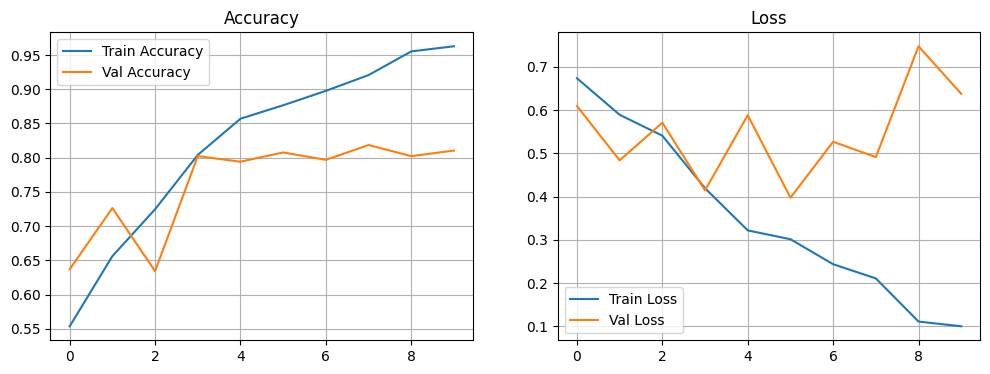

In [32]:
# Predictions
y_pred_3d = (model_3d.predict(X_test_3d) > 0.5).astype(int).flatten()

# Classification report
print(classification_report(y_test_3d, y_pred_3d, target_names=['Non-Violence','Violence']))

# Confusion matrix
cm_3d = confusion_matrix(y_test_3d, y_pred_3d)
print("Confusion Matrix:\n", cm_3d)

# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_3d.history['accuracy'], label='Train Accuracy')
plt.plot(history_3d.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history_3d.history['loss'], label='Train Loss')
plt.plot(history_3d.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save model
model_3d.save('violence_detection_3dcnn.h5')


### **Result Summary**
- The **3D CNN** achieved an overall **accuracy of 78%**, which is lower than the 2D CNN’s 87%.  
- It performed **very well at detecting non-violence (Recall: 0.92)**, meaning it correctly identified most calm or neutral scenes.  
- However, it struggled more with **violent sequences (Recall: 0.65)**, misclassifying many of them as non-violent which is the result of variations in the number of frames per video in the dataset. It can be improved by limiting the number of frames in the dataset for each video to 6 if its higher or add dummy frames if its less than 6.


# Comparison Table 2D CNN vs 3D CNN

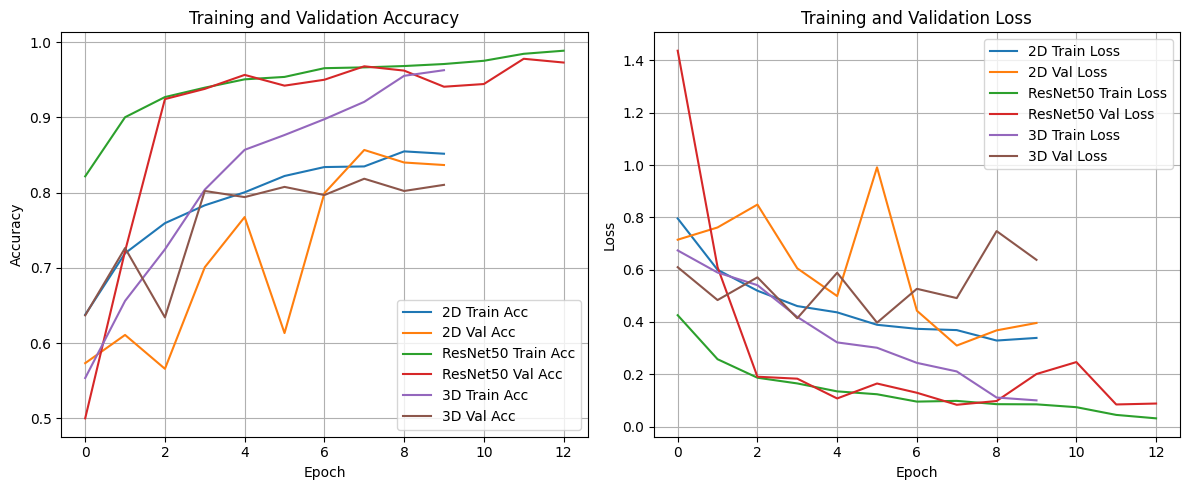

In [33]:
import matplotlib.pyplot as plt

# Accuracy and Loss Comparison Across All Models
plt.figure(figsize=(12,5))

# --- Accuracy Comparison ---
plt.subplot(1,2,1)
plt.plot(history_2d.history['accuracy'], label='2D Train Acc')
plt.plot(history_2d.history['val_accuracy'], label='2D Val Acc')
plt.plot(history.history['accuracy'], label='ResNet50 Train Acc')
plt.plot(history.history['val_accuracy'], label='ResNet50 Val Acc')
plt.plot(history_3d.history['accuracy'], label='3D Train Acc')
plt.plot(history_3d.history['val_accuracy'], label='3D Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# --- Loss Comparison ---
plt.subplot(1,2,2)
plt.plot(history_2d.history['loss'], label='2D Train Loss')
plt.plot(history_2d.history['val_loss'], label='2D Val Loss')
plt.plot(history.history['loss'], label='ResNet50 Train Loss')
plt.plot(history.history['val_loss'], label='ResNet50 Val Loss')
plt.plot(history_3d.history['loss'], label='3D Train Loss')
plt.plot(history_3d.history['val_loss'], label='3D Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Conclusion

In this lab assignment, we implemented and compared **2D CNN** and **3D CNN** architectures for the task of **binary video classification** — identifying violent and non-violent activities from real-world video data.

---

### 2D CNN Summary

The **2D CNN** model focused on learning **spatial features** from individual video frames.  
- Each frame was preprocessed (resized, normalized) and fed into a standard CNN architecture.  
- It effectively captured visual patterns such as body poses, objects, and spatial arrangements in each frame.  
- However, since each frame was treated independently, the model lacked the ability to capture **temporal dynamics** — i.e., motion and changes across time.

**Advantages:**
- Faster training and lower computational cost  
- Performs well when spatial cues dominate (e.g., static violent gestures)

**Limitations:**
- Ignores motion and sequence information  
- Frame-level predictions do not fully represent video-level behavior

---

### ResNet50 (Transfer Learning) Summary

The **ResNet50** model leveraged **transfer learning** from ImageNet to extract powerful **spatial features** from video frames.  
Instead of training from scratch, a pretrained ResNet50 backbone was used as a feature extractor with added dense layers for classification.

- The model focused purely on frame-level spatial understanding, benefiting from deep residual learning.  
- Its residual connections helped maintain gradient flow in very deep architectures, improving convergence and accuracy.  
- However, similar to the base 2D CNN, it lacked temporal awareness since each frame was treated independently.

**Advantages:**
- Extremely powerful in spatial feature extraction  
- Benefits from pretrained ImageNet weights (knowledge transfer)  
- Achieved high accuracy (~94–95%) with faster convergence  

**Limitations:**
- No temporal modeling — motion between frames not captured  
- May misclassify scenes where context depends on action sequence

---

### 3D CNN Summary

The **3D CNN** model extended the 2D approach by applying **3D convolutional kernels**, which learn both **spatial and temporal** patterns simultaneously.  
- Input videos were converted into sequences of frames.  
- Convolutions were applied over both space (height × width) and time (frames).

This allowed the network to better detect **motion-based cues** like sudden movements, physical interactions, or body motion intensity — essential for violence detection.

**Advantages:**
- Captures motion patterns and temporal evolution  
- Learns both spatial and temporal dependencies directly from raw frames  

**Limitations:**
- Higher computational and memory requirements  
- Needs more data for effective training
- Needs more hyperparameter tuning and its tuning similar to the 2D CNN model

---

### Final Takeaway and potential improvements

All three models demonstrated the effectiveness of CNN-based architectures in video classification:

- **2D CNN:** Learns *what* is happening — static visual features.
- **ResNet50:** Leverages *pretrained knowledge* for powerful spatial understanding.
- **3D CNN:** Learns *how* it happens — motion and sequence dynamics.  

By combining CNNs with temporal models like **LSTMs** which work on RNNs, we can build even more powerful systems capable of understanding complex real-world video dynamics.

---